<a href="https://colab.research.google.com/github/im-ysh/PLANT_DISEASE_CLASSIFICATION/blob/main/PLANT_DISEASE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os # for OS
import numpy as np # for arrays
import torch # for testing purpose
from torch.utils.data import DataLoader # to load the data
from torchvision import datasets, transforms # for preprocessing
import matplotlib.pyplot as plt # for graphs
from sklearn.utils import shuffle # to split the data into train & test
import pandas as pd # for csv / excel / to create dataframes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define class names
class_names = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___Healthy','Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Northern_Leaf_Blight','Grape___Black_rot']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMAGE_SIZE = (150,150)
BATCH_SIZE = 32 # to take input images in batches

In [ ]:
# Data Preprocessing (Data tranformastion)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), # resizing yhe image size
    transforms.ToTensor(), # convert into tensor type
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # normalization value(default value is mentioned in transform)
])

In [ ]:
#Load Datasets
train_dataset = datasets.ImageFolder(root = '/content/drive/MyDrive/plant disease using CNN/train', transform = transform) # for preprocessing purpose
test_dataset = datasets.ImageFolder(root = '/content/drive/MyDrive/plant disease using CNN/test', transform=transform)


In [ ]:
# loading the dataset
train_loader  = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True) # we shuffle only tain one because for any project its about our dataset
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
# check dataset size
n_train = len(train_dataset)
n_test = len(test_dataset)

print(f"number of training examples: {n_train}")  # inside print fxn xurly braces thers so that y
print(f"number of testing examples: {n_test}")
print(f"number of classes: {IMAGE_SIZE}")

number of training examples: 106
number of testing examples: 106
number of classes: (150, 150)


In [ ]:
#visualizing the dataset
def display_random_image(loader,class_names) :
  """
  Display a random image from dataset and its corresponding label
  """

  #get a batch of data
  dataiter = iter(loader)
  images, labels = next(dataiter) # use python's built-in next() fxn

  index = np.random.randint(len(labels)) # get a randoom index
  image = images[index].numpy().transpose(1,2,0) #transpose for correct display
  #unnormalize image for correcrt visulaization (revere of normalization)
  image = image*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
  image = np.clip(image,0,1) #clip to ensure valid pixel value

  plt.figure()
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False) # its an image so no need of griids
  plt.title(f'Image #{index} : {class_names[labels[index]]}')
  plt.show()

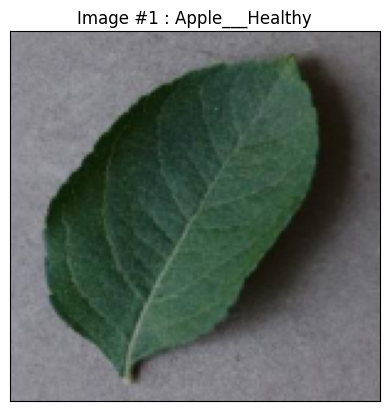

In [ ]:
# call the fxn
display_random_image(train_loader,class_names)

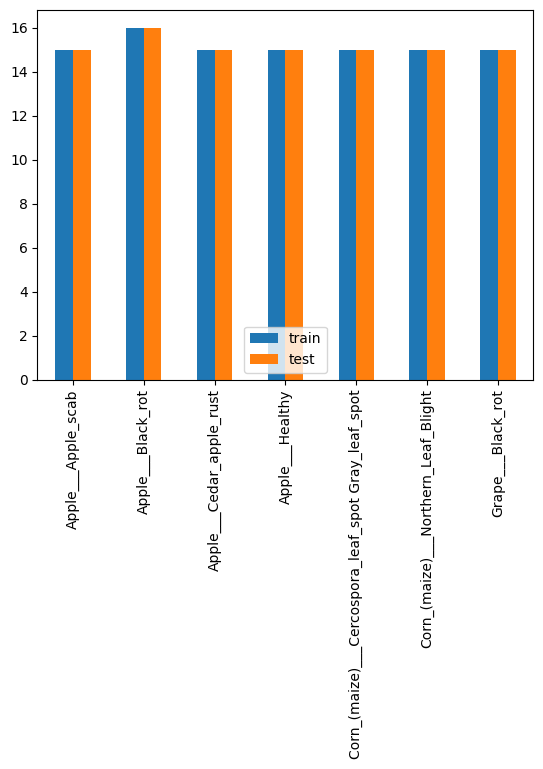

In [ ]:
# plotting dataset distribution
train_labels = [label for _,label in train_dataset]
test_labels = [label for _,label in test_dataset]
_, train_counts = np.unique(train_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)
pd.DataFrame({'train':train_counts, 'test':test_counts}, index = class_names).plot.bar()
plt.show()

In [ ]:
def display_examples(class_names,loader) :
  num_examples = 30
  dataiter = iter(loader)
  images,labels = next(dataiter)

  plt.figure(figsize = (25,25))
  for i in range(min(num_examples,len(images))) :
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

# convert tensore into numpy and clip values to [0,1] range for imshow
    image = images[i].numpy().transpose(1,2,0)
    image = np.clip(image,0,1) # clipping values to valid range

    plt.imshow(image)
    plt.xlabel(class_names[labels[i].item()])
  plt.show()

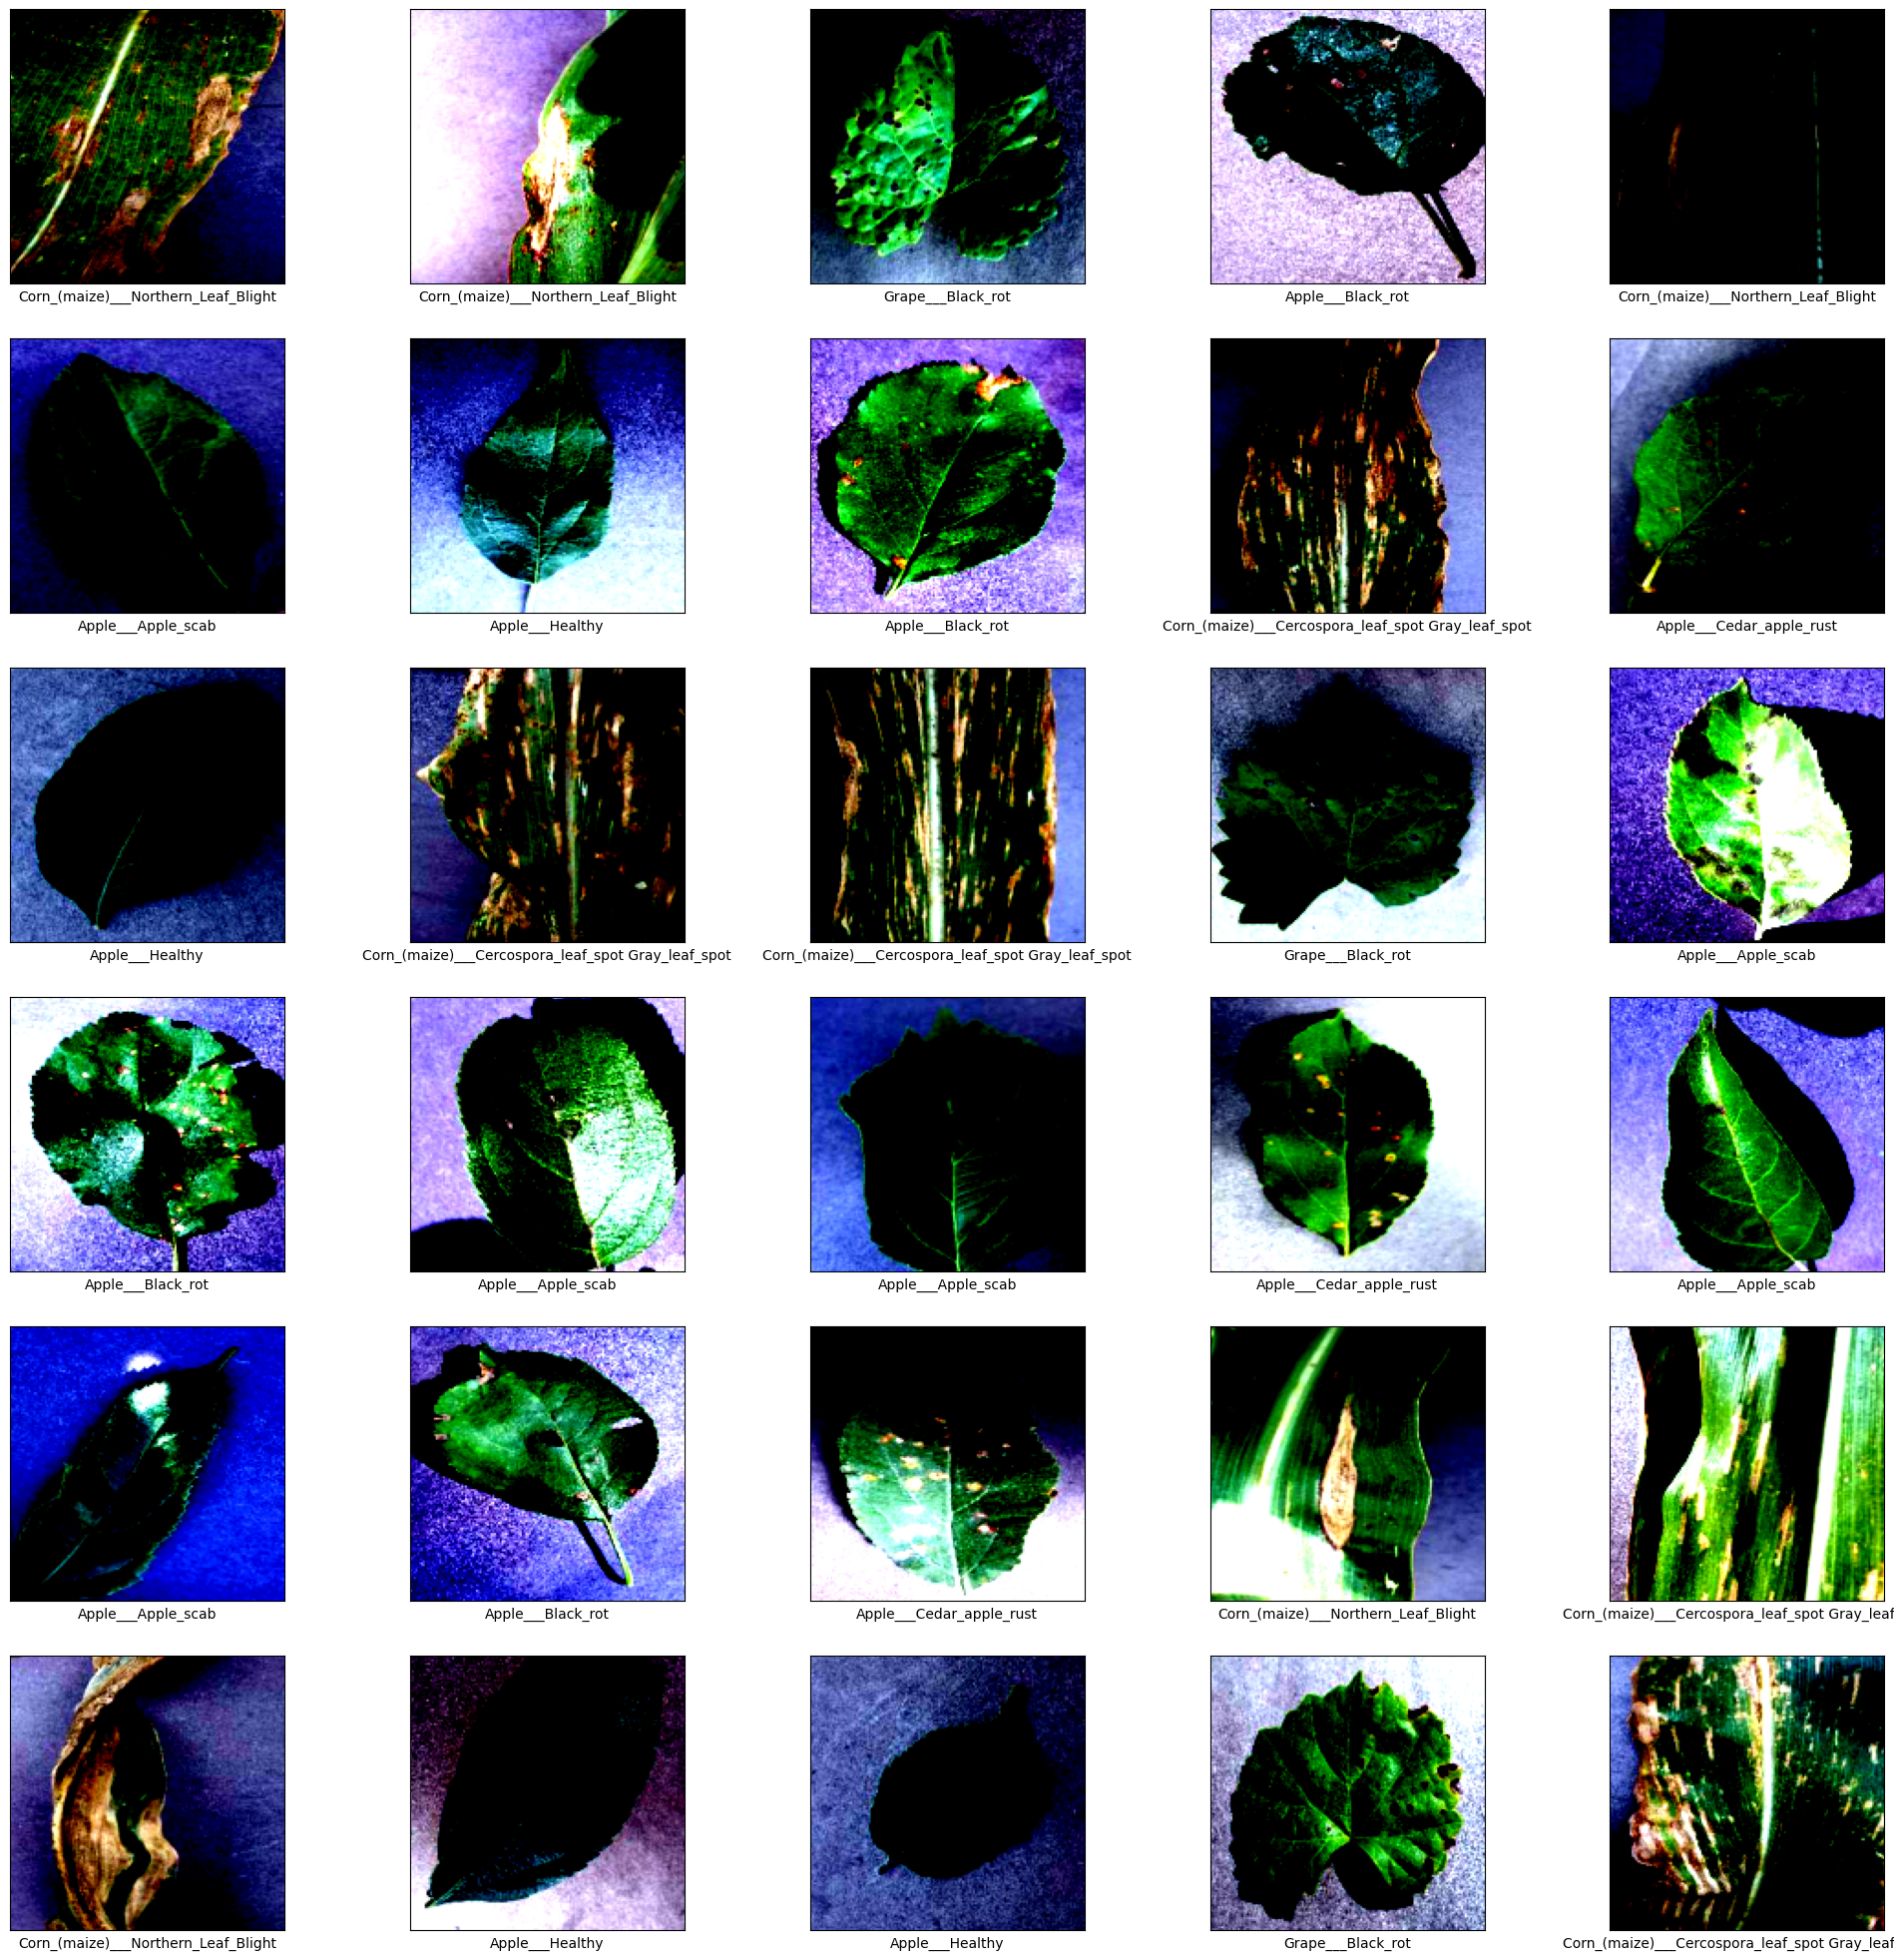

In [ ]:

display_examples(class_names,train_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim # optimiser - weight values , unbiased values for trying on input
import torchvision
import torchvision.transforms as transforms

# coonvulotyional layer , max pooling layer , ReLU,
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 3 input channels for RGB images
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

        # Calculate the size of the flattened feature vector
        self.flattened_size = self._get_flattened_size()

        # Define fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)  # Adjust based on the flattened size
        self.fc2 = nn.Linear(128, len(class_names))  # Output size is the number of classes

    def _get_flattened_size(self):
        # Use a dummy tensor to calculate the size after conv and pool layers
        with torch.no_grad():
            x = torch.zeros(1, 3, 150, 150)  # Input image size
            x = self.conv1(x)
            x = self.relu(x)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.relu(x)
            x = self.pool(x)
            return x.view(-1).size(0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, self.flattened_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Hyperparameters
batch_size = 32  # Adjust batch size according to your dataset and GPU/CPU memory
learning_rate = 0.001
num_epochs = 5

# Data transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to the required size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
trainset = torchvision.datasets.ImageFolder(root=r'/content/drive/MyDrive/plant disease using CNN/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.ImageFolder(root=r'/content/drive/MyDrive/plant disease using CNN/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define class names
class_names = trainset.classes  # Get class names from the dataset

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print('Finished Training')

# Testing the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Finished Training
Accuracy of the network on the test images: 75 %


In [17]:
#after training the model
torch.save(model.state_dict(), 'PLANT_DISEASE_CLASSIFICATION_model.pth') # h vs pth